In [ ]:
!apt-get install -y swig
!pip install gymnasium[box2d] pygame imageio opencv-python
!pip install stable-baselines3[extra]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (855 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubunt

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
from collections import deque

from gymnasium.wrappers import ResizeObservation, RecordVideo
from stable_baselines3 import PPO as SB3_PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecTransposeImage, VecFrameStack
from stable_baselines3.common.monitor import Monitor


In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CustomCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU()
        )
        self.policy_head = nn.Linear(512, num_actions)
        self.value_head = nn.Linear(512, 1)

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        fc_out = self.fc(conv_out)
        return self.policy_head(fc_out), self.value_head(fc_out)

In [ ]:
def make_env():
    def _init():
        env = gym.make("CarRacing-v3", render_mode="rgb_array")
        env = ResizeObservation(env, shape=(96, 96))
        env = Monitor(env)
        return env
    return _init

def wrap_env(env_fn, stack_frames=4):
    env = DummyVecEnv([env_fn])
    env = VecFrameStack(env, n_stack=stack_frames)
    env = VecTransposeImage(env)
    return env


In [ ]:
train_env = wrap_env(make_env())
model = SB3_PPO("CnnPolicy", train_env, verbose=1, tensorboard_log="./ppo_carracing_tensorboard/",
                learning_rate=3e-4, n_steps=2048, batch_size=64, n_epochs=10, gamma=0.99,
                clip_range=0.2, ent_coef=0.01)
model.learn(total_timesteps=500_000)
model.save("ppo_carracing")
train_env.close()

/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Streaming output truncated to the last 5000 lines.
|    loss                 | -0.000577  |
|    n_updates            | 170        |
|    policy_gradient_loss | -0.0198    |
|    std                  | 0.937      |
|    value_loss           | 0.167      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -42.4       |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 19          |
|    time_elapsed         | 550         |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.021212578 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.04       |
|    explained_variance   | 0.865       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.

Episode 1 Reward: [6.820415]
Episode 2 Reward: [6.3102565]
Episode 3 Reward: [6.656757]
Episode 4 Reward: [7.1202164]
Episode 5 Reward: [5.997561]


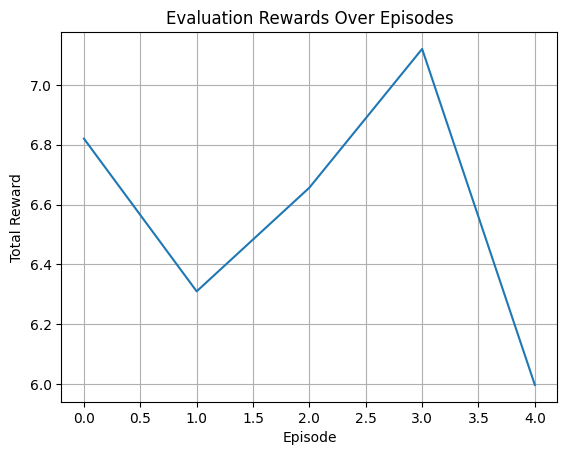

In [ ]:
eval_env = wrap_env(make_env())
model = SB3_PPO.load("ppo_carracing")
rewards = []

for ep in range(5):
    obs = eval_env.reset()
    done = False
    total = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, truncated = eval_env.step(action)
        done = done or truncated
        total += reward
    print(f"Episode {ep+1} Reward: {total}")
    rewards.append(total)

plt.plot(rewards)
plt.title("Evaluation Rewards Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.savefig("evaluation_rewards.png")
plt.show()
eval_env.close()

In [1]:
model = SB3_PPO.load("ppo_carracing")

env = gym.make("CarRacing-v3", render_mode="rgb_array")
obs, _ = env.reset()
frames = []

obs = np.transpose(obs, (2, 0, 1))  # Convert to (C, H, W)
stacked_obs = np.concatenate([obs] * 4, axis=0)  # Shape: (12, 96, 96)

for step in range(1000):
    frame = env.render()  # ← This will return (H, W, 3) frame
    frames.append(frame)

    action, _ = model.predict(stacked_obs, deterministic=True)
    next_obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    next_obs = np.transpose(next_obs, (2, 0, 1))
    stacked_obs = np.concatenate([stacked_obs[3:], next_obs], axis=0)  # Keep last 3 + new one

    if done:
        break

env.close()

os.makedirs("videos", exist_ok=True)
video_path = "videos/ppo_carracing_eval.mp4"
imageio.mimsave(video_path, frames, fps=30)
print(f"Video saved at: {video_path} ({len(frames)} frames)")

Video saved at: videos/ppo_carracing_eval.mp4 (426 frames)
